# Uploading the `Chest X-Ray` Dataset to Hugging Face

This notebook's goal is to preprocess and upload the dataset [Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj) to the **Hugging Face Hub**. 

There will be two version of this dataset. The first is a raw version of the images as provided by the **Guangzhou Women and Children's Medical Center** of the **University of California San Diego**. The second will be a preprocessed version of the dataset. 

You can also find this dataset availble in [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

## Setup

Let's first import the libraries we will use and create the constraints:

In [13]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image

# TensorFlow
import tensorflow as tf
from tensorflow import keras 
from keras import utils

# Hugging Face
import datasets
import huggingface_hub

In [2]:
# Local paths that store the files
RAW_DATA_PATH = "../data/raw/pneumonia_xray/"
DATA_PATH = "../data/processed/"
TFRECORDS_PATH = "../data/processed/"

NAME_RAW_DATASET = "mmenendezg/raw_pneumonia_x_ray"
NAME_DATASET = "mmenendezg/pneumonia_x_ray"
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (500, 500)
CLASSES = ["Normal", "Pneumonia"]

## Dataset Info

The dataset contains X-Ray chest images from independent patients. The images are classified into two classes:

>- 0: Normal
>- 1: Pneumonia

The shape, aspect ratio and size of the images vary. There are images with 3 channels of color (i.e., RGB color), and other images that have no channel (i.e., grayscale. The only channel is implicit). It is important to take this into consideration when preprocessing the dataset.

The structure of the folders of the original dataset is the following:

```
|-- pneumonia_x_ray
   |-- train
      |-- normal
      |-- pneumonia
   |-- test
      |-- normal
      |-- pneumonia
```

## Create Raw dataset

The first version of the dataset will be a raw version of the dataset. This will provide more flexibility to preprocess the images according to the project needs. 

It is important to login to Hugging Face to upload the dataset. In the code below change the `[TOKEN]` for the one provided by [Hugging Face](https://huggingface.co/settings/tokens).

In [3]:
!huggingface-cli login --token [TOKEN]

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/mmenendezg/.cache/huggingface/token
Login successful


The `load_dataset()` method allows us to download datasets stored in the Hugging Face Hub, or to load data stored locally. To load images from a local folder it is necessary to set `"imagefolder"` as the first argument, and the path of the folder containing the images in the `data_dir` argument. 

This will automatically identify the structure of the folders (see above) and create a `DatasetDict` containing the train and test splits, and it creates the two labels in each split.

In [4]:
raw_dataset = datasets.load_dataset("imagefolder", data_dir=RAW_DATA_PATH)
raw_dataset

Resolving data files: 100%|██████████| 624/624 [00:00<00:00, 14563.31it/s]
Found cached dataset imagefolder (/Users/mmenendezg/.cache/huggingface/datasets/imagefolder/default-2705360b7f09f3d9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 2/2 [00:00<00:00, 97.41it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5232
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})

Once we have loaded the data, we can push the dataset to the hub:

In [ ]:
raw_dataset.push_to_hub(NAME_RAW_DATASET)

The dataset has been successfully uploaded to the [Hub](https://huggingface.co/datasets/mmenendezg/raw_pneumonia_x_ray). We can now download the data using the same name set when pushing the dataset:

In [5]:
pneumonia_x_ray = datasets.load_dataset(NAME_RAW_DATASET)
pneumonia_x_ray

Found cached dataset parquet (/Users/mmenendezg/.cache/huggingface/datasets/mmenendezg___parquet/mmenendezg--raw_pneumonia_x_ray-719d20bbd0437f4e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 97.22it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5232
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
})

## Create Preprocessed Dataset

The raw images gives us a lot of flexibility to work with the data, but this creates some challenges when preprocessing the images to train a model. 

The second version of the dataset contains preprocessed images that solves the 2 main challenges of the raw data:

> - It converts all images to RGB (i.e., All the images have 3 channels)
> - It resizes them to a fixed size, and therefore, a fixed aspect ratio (1:1)

### Preprocess the images with TensorFlow

It is necessary to preprocess the images. TensorFlow offers a wide variety of methods to load and preprocess images. The method `tf.keras.utils.image_dataset_from_directory()` provides all the preprocessing we need. Additionally, it infers the labels of the images based on the structure of the folders.

When resizing the images, it is able to uses different interpolation methods. For this dataset we will use the `nearest` option that uses *k-nearest neighbors* algorithm to calculate the size of every pixel. This gives as result pixel values that are integers, and we do not need to process float values higher than 1. When working with images, it asumes that if the `dtype` of the tensors are float, the values should be betweeen 0 and 1.

In [16]:
def load_dataset(path: str, shuffle: bool = False) -> tf.data.Dataset:
    """Loads a dataset of images from a directory.

    Args:
        path: The path to the directory containing the images.
        shuffle: Whether to shuffle the dataset.

    Returns:
        A `tf.data.Dataset` of images and labels.
    """
    dataset = utils.image_dataset_from_directory(
        path,
        interpolation="nearest",
        image_size=IMG_SIZE,
        label_mode="int",
        color_mode="rgb",
        batch_size=None,
        shuffle=shuffle,
        class_names=["normal", "pneumonia"],
    )
    return dataset


Let's load the images from the raw data folder:

In [7]:
train_path = tf.io.gfile.join(RAW_DATA_PATH, "train")
test_path = tf.io.gfile.join(RAW_DATA_PATH, "test")

train_ds = load_dataset(train_path, shuffle=True)
test_ds = load_dataset(test_path)

Found 5232 files belonging to 2 classes.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Found 624 files belonging to 2 classes.


The original dataset only has `train` and `test` sets. Let's create a validation split set to upload it to the hub:

In [33]:
def create_validation_set(dataset: tf.data.Dataset, ratio: float = 0.3):
    # Calculate the number of images per label for the valid set
    normal_images = int(1349 * ratio)
    pneumo_images = int(3883 * ratio)

    # Separate the dataset per labels
    normal_ds = dataset.filter(lambda image, label: label == 0)
    pneumo_ds = dataset.filter(lambda image, label: label == 1)

    # Separate the datasets per splits
    normal_train = normal_ds.skip(normal_images)
    normal_valid = normal_ds.take(normal_images)

    pneumo_train = pneumo_ds.skip(pneumo_images)
    pneumo_valid = pneumo_ds.take(pneumo_images)

    # Concatenate the datasets
    train_ds = normal_train.concatenate(pneumo_train).shuffle(5000)
    valid_ds = normal_valid.concatenate(pneumo_valid)

    return train_ds, valid_ds


In [34]:
train_ds, valid_ds = create_validation_set(train_ds)

In [35]:
n_train = 0
for _, _ in train_ds:
    n_train += 1

n_valid = 0
for _, _ in valid_ds:
    n_valid += 1

n_test = 0
for _, _ in test_ds:
    n_test += 1

print(f"Train: {n_train}")
print(f"Valid: {n_valid}")
print(f"Test: {n_test}")

Train: 2096
Valid: 1568
Test: 624


Once the images have been processed, we need to convert them to `datasets.Dataset` (Hugging Face dataset object). The `datasets` library does not provide an specific method to create a dataset from `tf.data.Dataset`. There are several ways to achieve this: using a generator, creating a dictionary, converting the dataset to a pandas dataframe, etc. In this case we will save the dataset to images in a local folder, and then we wil load the dataset using the `dataset.load_dataset()` method as above.

In [38]:
def save_image(image_array: np.array, filepath: str):
    """Saves an image to a file.

    Args:
        image_array: The image array to save.
        filepath: The path to the file to save the image to.

    Returns:
        None.
    """
    image = Image.fromarray(image_array)
    image.save(filepath)


def save_images(dataset: tf.data.Dataset, set_type: str = "train"):
    """Saves images from a dataset to a directory.

    Args:
        dataset: A `tf.data.Dataset` of images and labels.
        set_type: The type of dataset, either `"train"`, `"validation"` or `"test"`.

    Returns:
        None.
    """
    id_images = [0, 0]
    classes = ["normal", "pneumonia"]
    paths = [
        f"../data/processed/{set_type}/{classes[0]}",
        f"../data/processed/{set_type}/{classes[1]}",
    ]
    for path in paths:
        tf.io.gfile.makedirs(path)

    for idx, (image, label) in enumerate(dataset):
        id_image = id_images[label.numpy()]
        image_path = tf.io.gfile.join(
            paths[label.numpy()], f"{set_type}-{id_image}.jpeg"
        )
        save_image(image.numpy(), image_path)
        id_images[label.numpy()] += 1


In [39]:
save_images(train_ds, "train")
save_images(valid_ds, "validation")
save_images(test_ds, "test")

### Upload preprocessed dataset to Hugging Face Hub

It is possible to load the whole dataset in a single line of code, but for a reason I was not able to find, this causes to duplicate the images. One alternative, is to load the sets separate and then to create a `datasets.DatasetDict` object containg both sets.

In [40]:
def create_and_upload_dataset_hf():
    """Creates and uploads a dataset to the Hugging Face Hub.

    This function creates a dataset from two directories, one for training and one for testing. 
    The dataset is then uploaded to the Hugging Face Hub.
    """
    train_path = tf.io.gfile.join(DATA_PATH, "train")
    valid_path = tf.io.gfile.join(DATA_PATH, "validation")
    test_path = tf.io.gfile.join(DATA_PATH, "test")

    train_dataset = datasets.load_dataset("imagefolder", data_dir=train_path, split="train")
    valid_dataset = datasets.load_dataset("imagefolder", data_dir=valid_path, split="validation")
    test_dataset = datasets.load_dataset("imagefolder", data_dir=test_path, split="test")
    dataset = datasets.DatasetDict({
        "train": train_dataset,
        "validation": valid_dataset,
        "test": test_dataset
    })
    dataset.push_to_hub(NAME_DATASET)

In [41]:
create_and_upload_dataset_hf()

Resolving data files: 100%|██████████| 2096/2096 [00:00<00:00, 138320.90it/s]


Extracting data files: 0it [00:00, ?it/s]
                                                        

Dataset imagefolder downloaded and prepared to /Users/mmenendezg/.cache/huggingface/datasets/imagefolder/default-6510b28c4af9a97d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files: 100%|██████████| 1568/1568 [00:00<00:00, 10437.27it/s]


Extracting data files: 0it [00:00, ?it/s]


Dataset imagefolder downloaded and prepared to /Users/mmenendezg/.cache/huggingface/datasets/imagefolder/default-e96f45b1df8e857c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files: 100%|██████████| 624/624 [00:00<00:00, 17311.09it/s]


Extracting data files: 0it [00:00, ?it/s]
Pushing split train to the Hub.                        


Dataset imagefolder downloaded and prepared to /Users/mmenendezg/.cache/huggingface/datasets/imagefolder/default-c95ddd26512b9f6b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [01:21<00:00, 81.83s/it]
Pushing split validation to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:59<00:00, 59.21s/it]
Pushing split test to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


The dataset has been successfully uploaded to the [Hub](https://huggingface.co/datasets/mmenendezg/pneumonia_x_ray).

## Images per Classes

Finally, lets see if the classes are balanced or not.

In [42]:
def plot_examples_per_class():
    """
    Plots the distribution of examples per class in the train and test datasets.

    The function calculates the count of examples for each class in the train and test datasets,
    and then visualizes the distribution using a bar plot.
    """
    count_train = [0, 0]
    count_valid = [0, 0]
    count_test = [0, 0]

    for _, label in train_ds:
        count_train[label.numpy()] += 1
    
    for _, label in valid_ds:
        count_valid[label.numpy()] += 1

    for _, label in test_ds:
        count_test[label.numpy()] += 1
    
    counts = {
        "Classes": ["Normal", "Pneumonia", "Normal", "Pneumonia", "Normal", "Pneumonia"],
        "Examples": count_train + count_valid + count_test,
        "Set": ["Train", "Train", "Valid", "Valid", "Test", "Test"],
    }
    data = pd.DataFrame.from_dict(counts)
    ax = sns.barplot(data, x="Examples", y="Set", hue="Classes", palette="magma")
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.show()

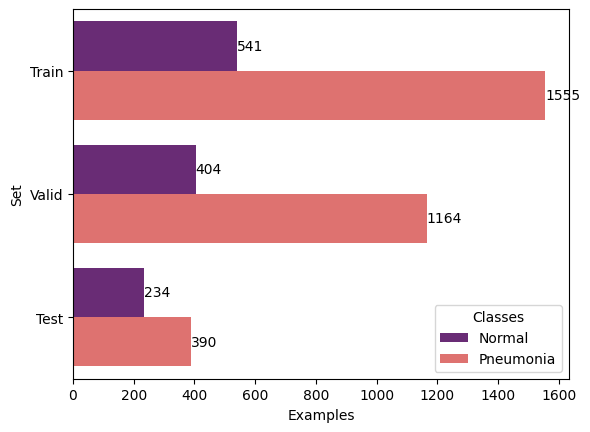

In [43]:
plot_examples_per_class()

The classes are unbalanced, specially the training set. Using the `accuracy` metric to evaluate a model trained on this dataset may not be the best option, and a better choice would be to use `recall`, `precision` or `F1-Score` metrics.

## References

>**References**:
>
> - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3